In [ ]:
from shapely.wkt import dumps
from pyproj import CRS

from shapely.geometry import shape, mapping
from pymongo.errors import BulkWriteError
import matplotlib.pyplot as plt
import multiprocessing as mp
from pprint import pprint
from typing import Dict
import geopandas as gpd
from shapely import wkt
import pandas as pd
import numpy as np
import os
import folium
import maup

# Useful functions

In [ ]:
# Demographic Heat Map of Precincts
# + Election Results (Pres, Sen, Gov, etc.)
def block_to_precinct(block_data: gpd.GeoDataFrame,
                      precinct_data: gpd.GeoDataFrame,
                      ):

    block_prec_assigns = maup.assign(block_data.geometry, precinct_data.geometry)
    return block_prec_assigns

def variable_grouping(assignment_data,
                      block_data,
                      precinct_data,
                      variables: list):
    precinct_data[variables] = block_data[variables].groupby(assignment_data).sum()
    return precinct_data

### Demographic Heat Map of Districts ###
def precinct_to_district():
    pass


def find_precinct_neighbors(precinct_data: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    '''Find the neighbors of each precinct in the precinct data and add it to the dataframe'''
    neighbors = maup.adjacencies(precinct_data)
    precinct_data['neighbors'] = neighbors
    return precinct_data

def rename_columns(dataframe: pd.DataFrame, columns_map: Dict) -> None:
    dataframe.rename(columns=columns_map, inplace=True)

def fill_missing_pop_w_normal_dist(dataframe: pd.DataFrame,
                                  name: str,
                                  column: pd.Series
                                  ) -> pd.Series:
    '''
    Randomly generating regions with a population of NaN
    using a gamma distribution which favors generating numbers at the lower range
    to prevent skewing our significant regions
    '''
    mean = column.mean()
    std = column.std()
    adj_std = np.clip(std / 1000, 0, std)
    adj_mean = np.clip(mean - std, 0, mean)
    is_null = column.isna()
    num_missing = is_null.sum()
    maximum_acceptable_pop = dataframe[name].max()
    # pprint(mean, std, maximum_acceptable_pop)
    
    if num_missing > 0:
        fill_values = np.random.default_rng().gamma(adj_mean, adj_std, num_missing)        
        column[is_null] = np.clip(fill_values, 0, maximum_acceptable_pop)
    return column

def calculate_state_wide_stats(dataframe: pd.DataFrame, columns: list, winning_party: str) -> pd.DataFrame:
    return dataframe[columns].astype(int).sum()

def combine_election_results(block_df: pd.DataFrame, precinct_df: pd.DataFrame) -> pd.DataFrame:
    block_precinct_assign = maup.assign(block_df, precinct_df)
    columns = []
    aggregated_election_results = block_df.groupby(block_precinct_assign).sum()
    return aggregated_election_results

### TRANSFORM FUNCTIONS ###

def to_math_crs(geometry_data):
    geometry_data.to_crs(epsg=32030, inplace=True)
    return geometry_data

def to_world_crs(geometry_data, crs=4326):
    geometry_data.to_crs(epsg=crs, inplace=True)
    return geometry_data

def simplify_geometry(geometry_data):
    geometry_data['geometry'] = geometry_data['geometry'].simplify(0.001)
    return geometry_data

### Data Observation Functions ###
def common_columns(precinct_data: gpd.GeoDataFrame, block_data: gpd.GeoDataFrame) -> None:
    pprint(precinct_data.columns.intersection(block_data.columns))

def missing_data(precinct_data: gpd.GeoDataFrame) -> None:
    pprint(precinct_data.isna().sum())

def print_columns(precinct_data: gpd.GeoDataFrame) -> None:
    pprint(precinct_data.columns)

def print_df(precinct_data: gpd.GeoDataFrame) -> None:
    pprint(precinct_data.head())

def print_spacer() -> None:
    pprint('------------')

def print_crs(data: gpd.GeoDataFrame) -> None:
    pprint(data.crs)

In [ ]:
# Get the current working directory
current_directory = os.getcwd()
move_up = os.path.dirname(current_directory)
client_dir = os.path.join(move_up, 'client')
data_dir = os.path.join(client_dir, 'public')
new_path = os.chdir(data_dir)
print(os.getcwd())

# Nevada Preprocessing

In [ ]:
nv_2022_gen_elc = gpd.read_file('NV/nv_2022_gen_prec/nv_2022_gen_prec.csv')

# Gather Attorney General + Gubernational Elections
nv_atg_gov_vote_2022 = nv_2022_gen_elc.iloc[:, :7].join(nv_2022_gen_elc.iloc[:, 12:16])
# Removing Non-Democratic/Non-Republican votes
nv_atg_gov_vote_2022.drop(['G22ATGOWRI', 'G22GOVOWRI', 'G22GOVLDAV'], axis=1, inplace=True)
nv_atg_gov_vote_2022['PREC'] = nv_atg_gov_vote_2022['PREC'].str.extract('(\d+)').astype(float)

# Some districts don't have numbers associated with them, when taking a closer look these districts
# don't have any votes associated with them so we are safe to drop them
nv_atg_gov_vote_2022.dropna(inplace=True)
nv_atg_gov_vote_2022['PREC'] = nv_atg_gov_vote_2022['PREC'].astype(int)
# Creating a unique id to join the dataframes on
nv_atg_gov_vote_2022['UNIQUE_ID'] = nv_atg_gov_vote_2022['COUNTYFP'] + '-' + nv_atg_gov_vote_2022['PREC'].astype(str)

Precinct-Level Gubernational and Attorney General Results from [Redistricting Data Hub](https://redistrictingdatahub.org/dataset/nevada-2022-general-election-precinct-level-results/)

In [ ]:
nv_vest_shp = gpd.read_file('NV/nv_vest_20/nv_vest_20.shp')

nv_vest_shp = nv_vest_shp[nv_vest_shp['NAME'] != 'Voting Districts Not Defined']
# Formating unique id column as the gubernational election dataframe
nv_vest_shp['UNIQUE_ID'] = nv_vest_shp['COUNTY'] + '-' + nv_vest_shp['VTDST'].str.lstrip('0')

Precinct-Level Presidential Data from [Redistricting Data Hub](https://redistrictingdatahub.org/dataset/vest-2020-nevada-precinct-boundaries-and-election-results-shapefile/)

### Merging Presidential, Gubernational, Attornery General Elections by Precinct

Using an outer join and removing precincts with missing geometry

We need geometries do this in order to assign block data to precincts

In [ ]:
nv_elections = pd.merge(nv_atg_gov_vote_2022, nv_vest_shp, on='UNIQUE_ID', how='outer')

In [ ]:
# Filter elections with geometry
nv_elections_precinct = gpd.GeoDataFrame(nv_elections[nv_elections.geometry != None])
nv_elections_precinct.reset_index(drop=True, inplace=True)
to_world_crs(nv_elections_precinct)
maup.doctor(nv_elections_precinct)

In [ ]:
# Fixing geometry
to_math_crs(nv_elections_precinct)
maup.smart_repair(nv_elections_precinct)

In [ ]:
# Changing back to Lat-Lon CRS
to_world_crs(nv_elections_precinct)
nv_elections_precinct.plot()

In [ ]:
unnecessary_columns = ['COUNTYFP_x', 'CNTY_NAME', 'PREC', 'COUNTYFP_y', 'COUNTY',
                       'VTDST', 'NAME', 'G20PRELJOR', 'G20PREIBLA', 'G20PREONON']

In [ ]:
nv_elections_precinct.drop(unnecessary_columns, axis=1, inplace=True)

In [ ]:
districtr_block_df = gpd.read_file('NV/districtr_nv_blockDemo/export-2657.shp')
display(districtr_block_df.columns)

Block-Level Demographic Data from [districtr](https://districtr.org/plan)

In [ ]:
nv_elections_precinct.to_crs(32611, inplace=True)
# print_crs(nv_elections_precinct)
districtr_block_df.to_crs(32611, inplace=True)
# print_crs(districtr_block_df)

In [ ]:
nv_blocks_to_precinct_assignments = maup.assign(districtr_block_df.geometry, nv_elections_precinct.geometry)

In [ ]:
nv_blocks_to_precinct_assignments = block_to_precinct(districtr_block_df, nv_elections_precinct)

In [ ]:
nv_block_columns = ['VAP', 'WVAP', 'BVAP', 'ASIANVAP', 'HVAP']
# nv_elections_precinct[nv_block_columns] = districtr_block_df[nv_block_columns].groupby(nv_blocks_to_precinct_assignments).sum()
nv_elections_precinct = variable_grouping(assignment_data=nv_blocks_to_precinct_assignments,
                  block_data=districtr_block_df,
                  precinct_data=nv_elections_precinct,
                  variables=nv_block_columns)

In [ ]:
columns_to_fill = ['G22ATGDFOR', 'G22ATGRCHA', 'G22GOVDSIS', 'G22GOVRLOM',
                   'VAP', 'WVAP', 'BVAP', 'ASIANVAP', 'HVAP']
vote_results_to_int = ['G22ATGDFOR', 'G22ATGRCHA', 'G22GOVDSIS', 'G22GOVRLOM', 'G20PREDBID',
                       'G20PRERTRU', 'VAP', 'WVAP', 'BVAP', 'ASIANVAP', 'HVAP']

Before merging, some of the vote results were formatted as strings rather than integers. \
We reformat all of the voting results as integers for santiy and completeness.

In [ ]:
for column in vote_results_to_int:
    nv_elections_precinct[column] = pd.to_numeric(nv_elections_precinct[column], errors='coerce')


Randomly generate missing values

In [ ]:
for column_name in columns_to_fill:
    fill_missing_pop_w_normal_dist(dataframe=nv_elections_precinct,
                                   name=column_name,
                                   column=nv_elections_precinct[column_name])
    

Some values came out as decimals! We can't have partial votes! \
We reformat values into whole integers again

In [ ]:
nv_elections_precinct[columns_to_fill] = np.ceil(nv_elections_precinct[columns_to_fill]).astype(int)

We reorganize the column names for readiability and formatting

In [ ]:
new_column_order = ['UNIQUE_ID', 'STATEFP', 'G20PREDBID', 'G20PRERTRU',
                    'G22ATGDFOR', 'G22ATGRCHA', 'G22GOVDSIS', 'G22GOVRLOM',
                   'VAP', 'WVAP', 'BVAP', 'ASIANVAP', 'HVAP', 'geometry']
nv_elections_precinct['STATEFP'] = 'Nevada'
nv_elections_precinct = nv_elections_precinct[new_column_order]
# rename_columns(dataframe=nv_elections_precinct, columns_map=)

In [ ]:
nv_elections_precinct.to_file('nv_data.geojson', driver='GeoJSON')

# Mississippi Preprocessing

Precinct-Level Election

<Axes: >

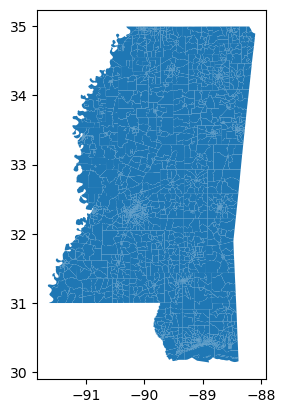

In [166]:
ms_districtr_block_df = gpd.read_file('MS/ms-block-demo-2020.geojson')
# ms_districtr_block_df.plot()

Block-Level Demographic Data from [district](https://districtr.org/plan)

### Assigning Demographic data on the Block Level to Election Results on the Precinct Level

Using the Maup library we assign blocks to precincts